# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [ ]:
# Update the PATH to include the user installation directory.
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [ ]:
# Install requirements
!python -m pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader
# Define transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to Tensor
    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
training_data = datasets.MNIST(root ="data", train= True, download =True, transform = transform)
train_loader = DataLoader(training_data, batch_size= 32, shuffle= True)
# Create test set and define test dataloader
test_data = datasets.MNIST(root ="data", train= False, download =True, transform = transform)
test_loader = DataLoader(test_data, batch_size= 32)

100%|██████████| 9912422/9912422 [00:00<00:00, 101844839.00it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 61148760.13it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25103965.29it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3113849.10it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I want to to transform into from the input image file to tensor
With my transformation using activation Relu since my data is center around [-1, 1]
I uyse flatten because we are having a 28x28 input matrix and i want to flatten it to 784 to build feed foward neural network

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [ ]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.figure(figsize=(1, 1))
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [ ]:
print(f"Amount of training samples:  + {len(training_data)}")
images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape[1:]}")

Amount of training samples:  + 60000
Image shape: torch.Size([1, 28, 28])


6


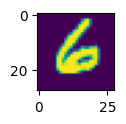

7


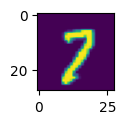

0


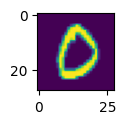

5


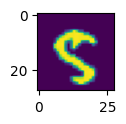

1


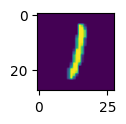

In [ ]:
# Explore data

show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28*28,120)
        self.layer2 = nn.Linear(120, 84)
        self.layer3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
net = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [5]:
#May use SGD
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer =optim.SGD(net.parameters(), lr = 0.01, momentum =0.9)

criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [6]:
num_epochs = 20

best_val_loss = float('inf')

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()
train_acc_history = list()
val_acc_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of the model and compute the loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backpropagate the loss and perform optimization
        loss.backward()
        optimizer.step()

        # Compute the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1} training accuracy: {100 * train_correct/len(training_data):.2f}% training loss: {train_loss/len(train_loader):.5f}')

    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(100 * train_correct/len(training_data))

    # Validation
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:  # Renamed to val_loader for clarity
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    print(f'Epoch {epoch + 1} validation accuracy: {100 * val_correct/len(test_data):.2f}% validation loss: {val_loss/len(test_loader):.5f}')  # Assuming val_data is defined somewhere in your code

    val_loss_history.append(val_loss/len(test_loader))
    val_acc_history.append(100 * val_correct/len(test_data))

Epoch 1 training accuracy: 89.46% training loss: 0.34808
Epoch 1 validation accuracy: 94.01% validation loss: 0.19922
Epoch 2 training accuracy: 94.83% training loss: 0.16922
Epoch 2 validation accuracy: 95.35% validation loss: 0.15149
Epoch 3 training accuracy: 95.95% training loss: 0.12884
Epoch 3 validation accuracy: 96.69% validation loss: 0.10918
Epoch 4 training accuracy: 96.65% training loss: 0.10557
Epoch 4 validation accuracy: 95.88% validation loss: 0.12857
Epoch 5 training accuracy: 97.14% training loss: 0.09272
Epoch 5 validation accuracy: 96.95% validation loss: 0.10105
Epoch 6 training accuracy: 97.41% training loss: 0.08251
Epoch 6 validation accuracy: 96.60% validation loss: 0.10905
Epoch 7 training accuracy: 97.61% training loss: 0.07416
Epoch 7 validation accuracy: 97.15% validation loss: 0.10088
Epoch 8 training accuracy: 97.83% training loss: 0.06660
Epoch 8 validation accuracy: 97.07% validation loss: 0.10236
Epoch 9 training accuracy: 98.00% training loss: 0.06050

Plot the training loss (and validation loss/accuracy, if recorded).

<ipython-input-7-cfa2ade5b87d>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


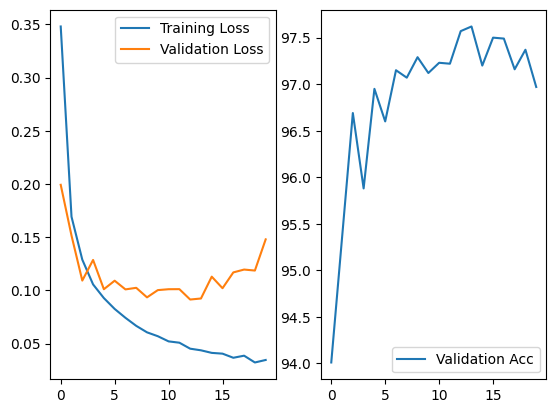

In [7]:
# Plot the training and validation loss history
fig, ax1 = plt.subplots()
plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_acc_history, label="Validation Acc")

plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [8]:
net.eval()
correct = 0
total = 0

with torch.no_grad():  # Deactivate gradients for the following code
    for data in test_loader:
        images, labels = data

        # Forward pass
        outputs = net(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)  # Increment the total count
        correct += (predicted == labels).sum().item()  # Increment correct count

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on test images: {accuracy:.2f}%')

Accuracy of the network on test images: 96.97%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28*28,400)
        self.dropout1 = nn.Dropout(0.25)
        self.layer2 = nn.Linear(400, 205)
        self.dropout2 = nn.Dropout(0.25)
        self.layer3 = nn.Linear(205, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.layer1(x))
        x = self.dropout1(x)
        x = self.activation(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x)
        return x

# Instantiate the model
net = Net()

In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.00025)
# optimizer =optim.SGD(net.parameters(), lr = 0.01, momentum =0.9)

criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(training_data, batch_size= 256, shuffle= True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)


Net(
  (layer1): Linear(in_features=784, out_features=400, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (layer2): Linear(in_features=400, out_features=205, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (layer3): Linear(in_features=205, out_features=10, bias=True)
)

In [11]:
num_epochs = 40
patience = 5
best_val_loss = float('inf')

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()
train_acc_history = list()
val_acc_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of the model and compute the loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backpropagate the loss and perform optimization
        loss.backward()
        optimizer.step()

        # Compute the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1} training accuracy: {100 * train_correct/len(training_data):.2f}% training loss: {train_loss/len(train_loader):.5f}')

    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(100 * train_correct/len(training_data))

    # Validation
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:  # Renamed to val_loader for clarity
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    print(f'Epoch {epoch + 1} validation accuracy: {100 * val_correct/len(test_data):.2f}% validation loss: {val_loss/len(test_loader):.5f}')  # Assuming val_data is defined somewhere in your code

    val_loss_history.append(val_loss/len(test_loader))
    val_acc_history.append(100 * val_correct/len(test_data))

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(net.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1

    # Early stopping
    if no_improve_epochs >= patience:
        print("Early stopping!")
        break




Epoch 1 training accuracy: 78.69% training loss: 0.72934
Epoch 1 validation accuracy: 90.70% validation loss: 0.31344
Epoch 2 training accuracy: 90.19% training loss: 0.32667
Epoch 2 validation accuracy: 93.30% validation loss: 0.23108
Epoch 3 training accuracy: 92.48% training loss: 0.25177
Epoch 3 validation accuracy: 94.41% validation loss: 0.18855
Epoch 4 training accuracy: 93.81% training loss: 0.20519
Epoch 4 validation accuracy: 95.29% validation loss: 0.15571
Epoch 5 training accuracy: 94.88% training loss: 0.17400
Epoch 5 validation accuracy: 95.94% validation loss: 0.13065
Epoch 6 training accuracy: 95.57% training loss: 0.14948
Epoch 6 validation accuracy: 96.49% validation loss: 0.11740
Epoch 7 training accuracy: 96.20% training loss: 0.13173
Epoch 7 validation accuracy: 96.74% validation loss: 0.10584
Epoch 8 training accuracy: 96.47% training loss: 0.11680
Epoch 8 validation accuracy: 97.18% validation loss: 0.09416
Epoch 9 training accuracy: 96.68% training loss: 0.10890

<ipython-input-12-cfa2ade5b87d>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


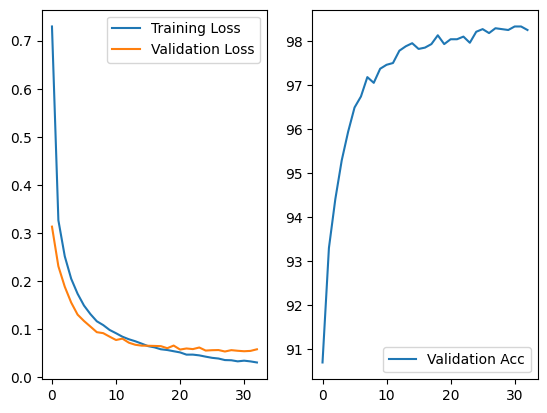

In [12]:
# Plot the training and validation loss history
fig, ax1 = plt.subplots()
plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_acc_history, label="Validation Acc")

plt.legend()
plt.show()

In [13]:
net.load_state_dict(torch.load('best_model.pth'))
net.eval()
correct = 0
total = 0

with torch.no_grad():  # Deactivate gradients for the following code
    for data in test_loader:
        images, labels = data

        # Forward pass
        outputs = net(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)  # Increment the total count
        correct += (predicted == labels).sum().item()  # Increment correct count

# Calculate the accuracy
new_accuracy = 100 * correct / total
print(f'Accuracy of the network on test images: {new_accuracy:.2f}%')
dif = new_accuracy - accuracy
print(f'Diference in Accuracy of the network on test images: {dif:.2f}%')

Accuracy of the network on test images: 98.29%
Diference in Accuracy of the network on test images: 1.32%


## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
torch.save(net.state_dict(), 'best_model.pth')